# Telco Customer Churn Prediction
`References`:
[1](https://www.kaggle.com/blastchar/telco-customer-churn/kernels?sortBy=hotness&group=everyone&pageSize=20&datasetId=13996&language=Python)
[2](https://www.kaggle.com/bandiatindra/telecom-churn-prediction)

## Introduction
In this notebook we will predict if *a customer left the company in the last month (**churn**)*. 

Using the Sklearn library, three algorithms will be implemented: Logistic Regression, Support Vector Machine and Nearest Neighbors. This library also includes the preprocessing and metrics used here. Since our dataset has some imbalance, we need a more reliable metric than accuracy to measure our models. Therefore, the area under the ROC curve will be our optimization objective, but we will also look at the accuracy at each experiment.

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.precision", 2)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')
import matplotlib.ticker as mtick # For specifying the axes tick format

# Sklearn imports
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('./WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_orig = df.copy(deep=True)
print(df.shape)
df.head(2).T

(7043, 21)


,0,1
customerID,7590-VHVEG,5575-GNVDE
gender,Female,Male
SeniorCitizen,0,0
Partner,Yes,No
Dependents,No,No
tenure,1,34
PhoneService,No,Yes
MultipleLines,No phone service,No
InternetService,DSL,DSL
OnlineSecurity,No,Yes


In [3]:
print(df.columns)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [5]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Impute missing values

There are only 11 missing values, all of them for the `TotalCharges` column. This values are actually a blank space in the csv file and are exclusive for customers with zero tenure. It's possible to concluded that they are missing due to the fact that the customer never paied anything to the company. We will impute this missing values with zero:


In [6]:
df['TotalCharges'] = df['TotalCharges'].replace(" ", 0).astype('float32')
df = df.drop(['customerID'], axis=1)

### Target variable

We are trying to predict if the client left the company in the previous month. Therefore we have a binary classification problem with a slightly unbalanced target:

In [7]:
print('Churn(No):', round((df['Churn'].value_counts()[0]/len(df)) * 100, 2), '%')
print('Churn(Yes):', round((df['Churn'].value_counts()[1]/len(df)) * 100, 2), '%')

Churn(No): 73.46 %
Churn(Yes): 26.54 %


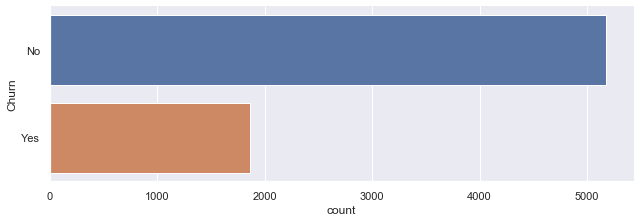

In [8]:
ax = sns.catplot(y="Churn", kind="count", data=df, height=3, aspect=3, orient='h', legend=True)

## Numerical features

There are only three numerical columns: **tenure**, **monthly charges** and **total charges**. The probability density distribution can be estimate using the seaborn kdeplot function.

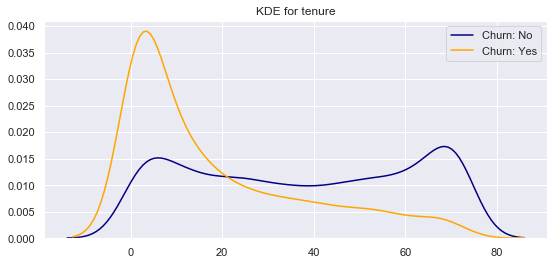

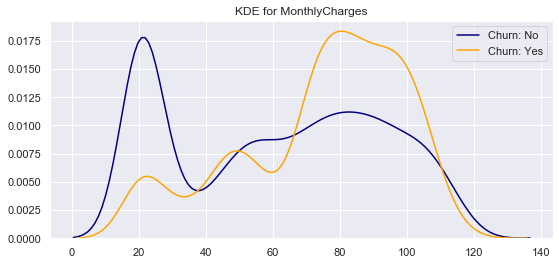

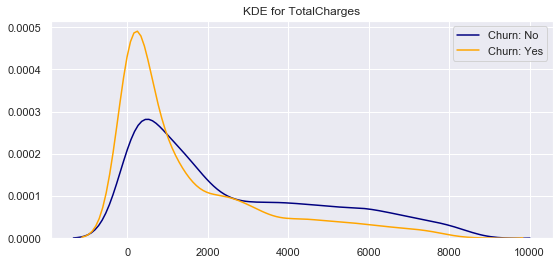

In [9]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Churn'] == 'No'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Churn'] == 'Yes'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

From the plots above we can conclude that:

* Recent clients are more likely to churn
* Clients with higher **MonthlyCharges** are also more likely to churn
* **Tenure** and **MonthlyCharges** are probably important features

In fact we can see some boundaries when we use scatter plots:


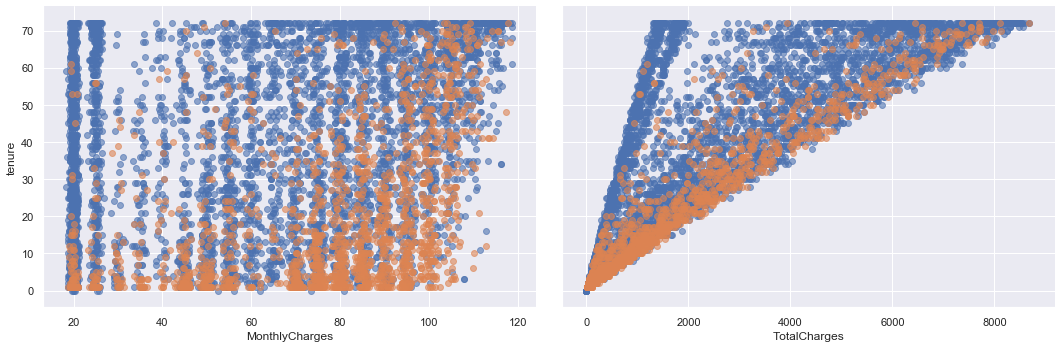

In [10]:
g = sns.PairGrid(df, y_vars=["tenure"], x_vars=["MonthlyCharges", "TotalCharges"], height=5, hue="Churn", aspect=1.5)
ax = g.map(plt.scatter, alpha=0.6)

Another feature we can consider is the difference between the **MonthlyCharges** and the **TotalCharges** divided by the **tenure**:

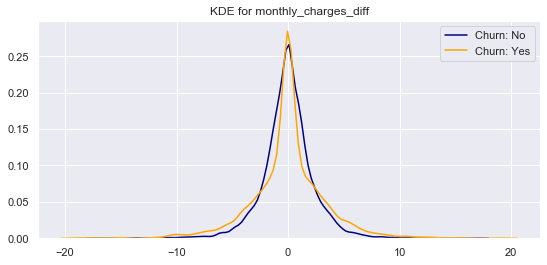

In [11]:
# Calculate features
df['total_charges_to_tenure_ratio'] = df['TotalCharges'] / df['tenure']
df['monthly_charges_diff'] = df['MonthlyCharges'] - df['total_charges_to_tenure_ratio']
kdeplot('monthly_charges_diff')

Not a promising feature at first glance, but it might be useful when combined with categorical features.

## Categorical features

This dataset has 16 categorical features:

* Six binary features (Yes/No)
* Nine features with three unique values each (categories)
* One feature with four unique values



### Gender and Age (SeniorCitizen)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


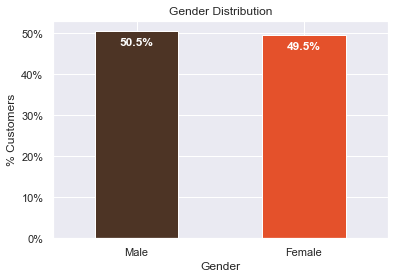

In [12]:
colors = ['#4D3425','#E4512B']
ax = (df['gender'].value_counts() * 100.0 / len(df)).plot(kind='bar', stacked = True, rot = 0, colors = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers')
ax.set_xlabel('Gender')
ax.set_ylabel('% Customers')
ax.set_title('Gender Distribution')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x() + .15,
            i.get_height() - 3.5, 
            str(round((i.get_height() / total), 1)) + '%',
            fontsize=12, color='white',
            weight='bold')

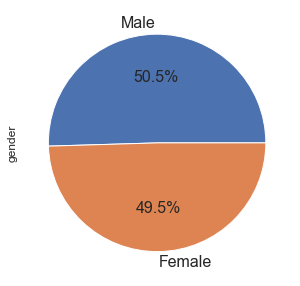

In [13]:
ax = (df['gender'].value_counts() * 100.0 / len(df)).plot.pie(autopct='%.1f%%', labels = ['Male', 'Female'],figsize =(5,5), fontsize = 16)

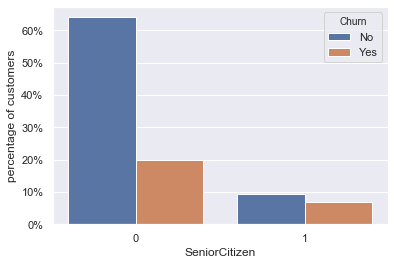

In [14]:
def barplot_percentages(feature, orient='v', axis_name="percentage of customers"):
    ratios = pd.DataFrame()
    g = df.groupby(feature)["Churn"].value_counts().to_frame()
    g = g.rename({"Churn": axis_name}, axis=1).reset_index()
    g[axis_name] = g[axis_name]/len(df)
    if orient == 'v':
        ax = sns.barplot(x=feature, y= axis_name, hue='Churn', data=g, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x= axis_name, y=feature, hue='Churn', data=g, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.plot()
barplot_percentages("SeniorCitizen")

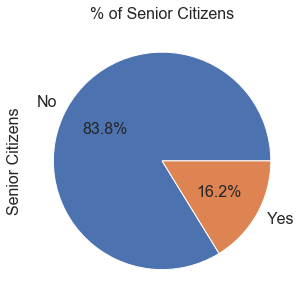

In [15]:
ax = (df['SeniorCitizen'].value_counts() * 100.0 / len(df)).plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'], figsize =(5,5), fontsize = 16)     
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 16)
ax.set_title('% of Senior Citizens', fontsize = 16)
plt.show()

There are only 16% of the customers who are senior citizens. Thus most of our customers in the data are younger people.

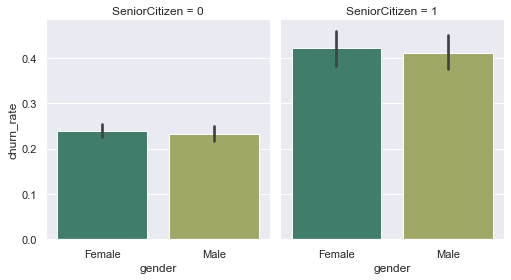

In [16]:
df['churn_rate'] = df['Churn'].replace("No", 0).replace("Yes", 1)
g = sns.FacetGrid(df, col="SeniorCitizen", height=4, aspect=.9)
ax = g.map(sns.barplot, "gender", "churn_rate", palette = "gist_earth", order= ['Female', 'Male'])

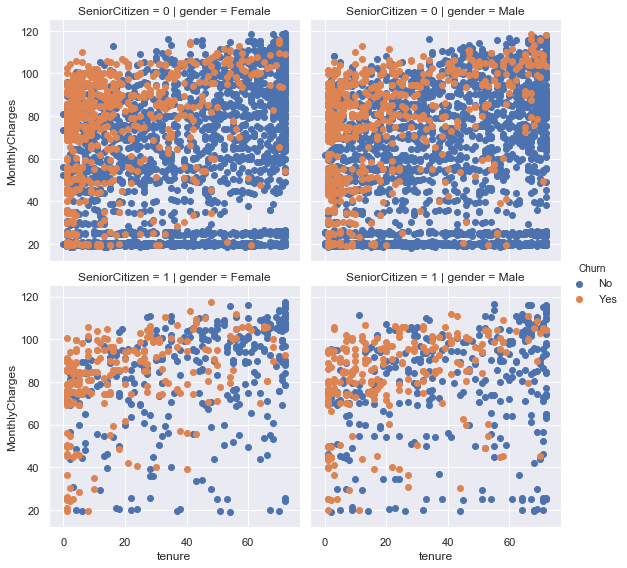

In [17]:
g = sns.FacetGrid(df, row='SeniorCitizen', col="gender", hue="Churn", height=4)
g.map(plt.scatter, "tenure", "MonthlyCharges", alpha=1)
g.add_legend()
plt.show()

* `Gender` is not an indicative of churn.
* `SeniorCitizens` are only 16% of customers, but they have a much higher churn rate: **42% against 23% for non-senior customers**.
* There are no special relations between this categorical values and the main numerical features.

### Partner and dependents

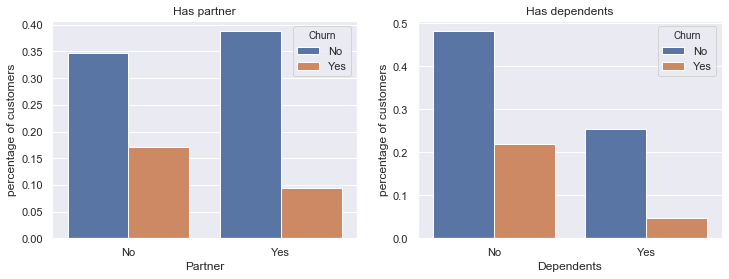

In [18]:
fig, axis = plt.subplots(1, 2, figsize=(12,4))
axis[0].set_title("Has partner")
axis[1].set_title("Has dependents")
axis_y = "percentage of customers"
# Plot Partner column
gp_partner = df.groupby('Partner')["Churn"].value_counts()/len(df)
gp_partner = gp_partner.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Partner', y= axis_y, hue='Churn', data=gp_partner, ax=axis[0])
# Plot Dependents column
gp_dep = df.groupby('Dependents')["Churn"].value_counts()/len(df)
gp_dep = gp_dep.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Dependents', y= axis_y, hue='Churn', data=gp_dep, ax=axis[1])

* Customers that doesn't have partners are more likely to churn
* Customers without dependents are also more likely to churn

### Phone and Internet services

Now let's look at the services that customers are using. There are only two main services: phone and internet but the former has many additionals like online backup and security.

**Phone services**

There are only two features here: if the client has phone and if he has more than one line. Both can be summed up in one chart:

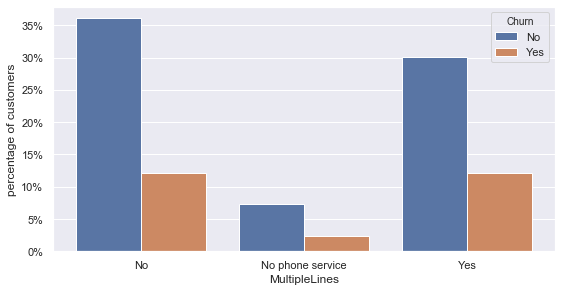

In [19]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("MultipleLines", orient='v')

* Few customers doesn't have phone service
* Customers with multiple lines have a slightly higher churn rate

Let's see how multiple lines affects the monthly charges:


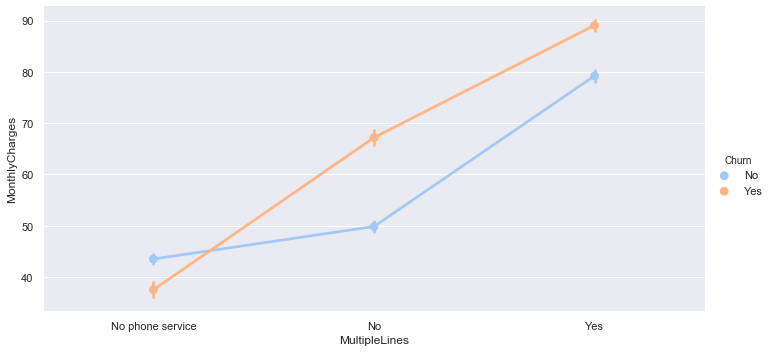

In [20]:
ax = sns.catplot(x="MultipleLines", y="MonthlyCharges", hue="Churn", kind="point",
                 split=True, palette="pastel", data=df, height=5, aspect=2)

**Internet services**

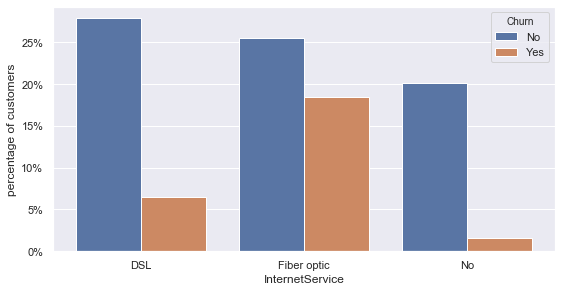

In [21]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("InternetService", orient="v")

* Clients without internet have a very low churn rate
* Customers with fiber are more probable to churn than those with DSL connection

Comparing the Internet service with monthly charges:

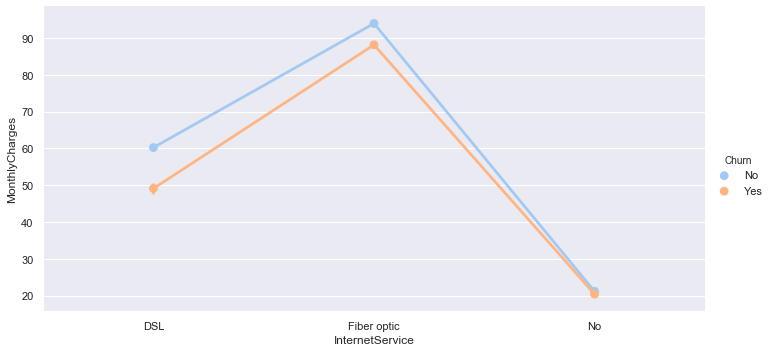

In [22]:
ax = sns.catplot(x="InternetService", y="MonthlyCharges", hue="Churn", kind="point",
                 split=True, palette="pastel", data=df, height=5, aspect=2);

It's interesting how customers with DSL (slower connection) and higher charges are less probable to churn.



**Additional services**

There are six additional services for customers with internet:


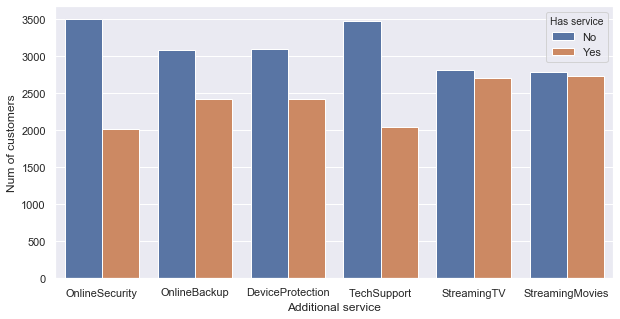

In [23]:
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
df1 = pd.melt(df[df["InternetService"] != "No"][cols]).rename({'value': 'Has service'}, axis=1)
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df1, x='variable', hue='Has service')
ax.set(xlabel='Additional service', ylabel='Num of customers')
plt.show()

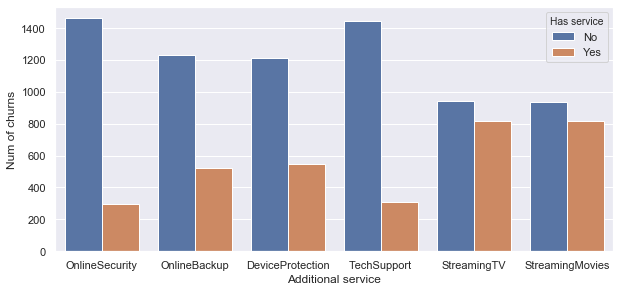

In [24]:
plt.figure(figsize=(10, 4.5))
df1 = df[(df.InternetService != "No") & (df.Churn == "Yes")]
df1 = pd.melt(df1[cols]).rename({'value': 'Has service'}, axis=1)
ax = sns.countplot(data=df1, x='variable', hue='Has service', hue_order=['No', 'Yes'])
ax.set(xlabel='Additional service', ylabel='Num of churns')
plt.show()

The first plot shows the total number of customers for each additional service, while the second shows the number of clients that churn. We can see that:

* Customers with the first 4 additionals (security to tech support) are more unlikely to churn
* Streaming service is not predictive for churn



### Contract and Payment

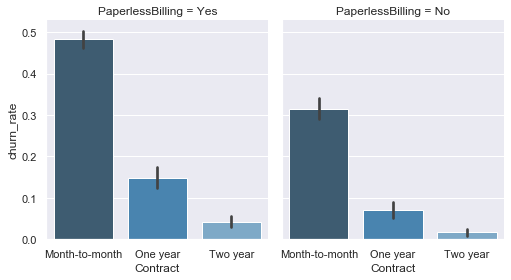

In [25]:
g = sns.FacetGrid(df, col="PaperlessBilling", height=4, aspect=.9)
ax = g.map(sns.barplot, "Contract", "churn_rate", palette = "Blues_d", order= ['Month-to-month', 'One year', 'Two year'])

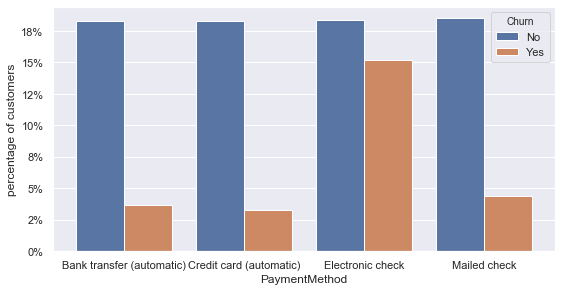

In [26]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("PaymentMethod", orient='v')

A few observations:

* Customers with paperless billing are more probable to churn.
* The preferred payment method is Electronic check with around 35% of customers. This method also has a very high churn rate
* Short term contracts have higher churn rates

One and two year contracts probably have contractual fines and therefore customers have to wait untill the end of contract to churn. 

A time-series dataset would be better to understand this kind of behaviour. Now let's have a look at the relation with numerical features:


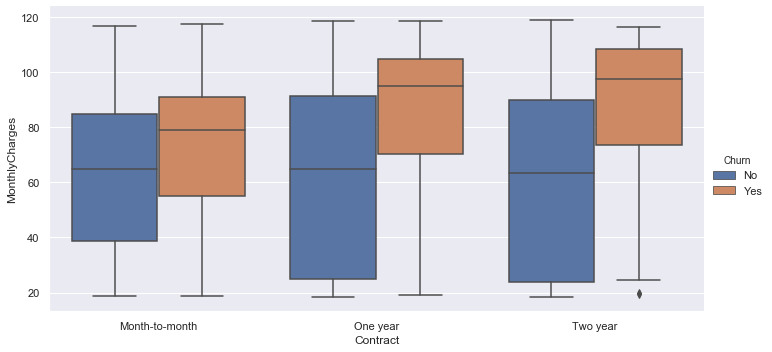

In [27]:
ax = sns.catplot(x="Contract", y="MonthlyCharges", hue="Churn", kind="box", data=df, height=5, aspect=2)

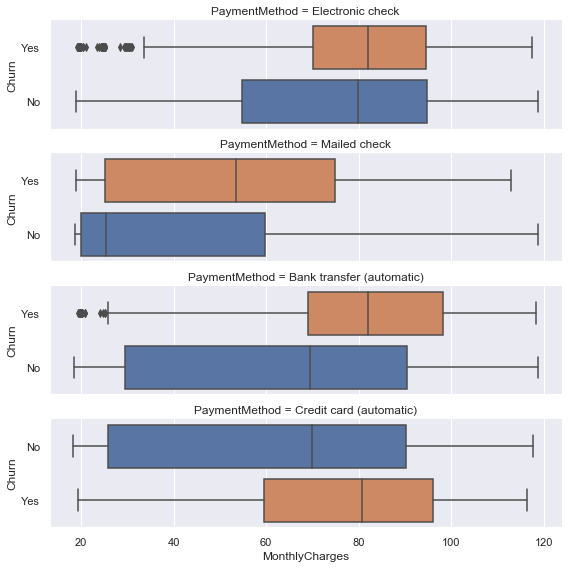

In [28]:
ax = sns.catplot(y="Churn", x="MonthlyCharges", row="PaymentMethod", kind="box", data=df, height=2, aspect=4, orient='h')

* Longer contracts are more affected by higher monthly charges (for churn rate).
* Mailed checks have lower charges
* There is a huge gap in charges between customers that churn and those that don't with respect to Mailed Check

## Correlation between features

Correlation heatmap (Pearson method)


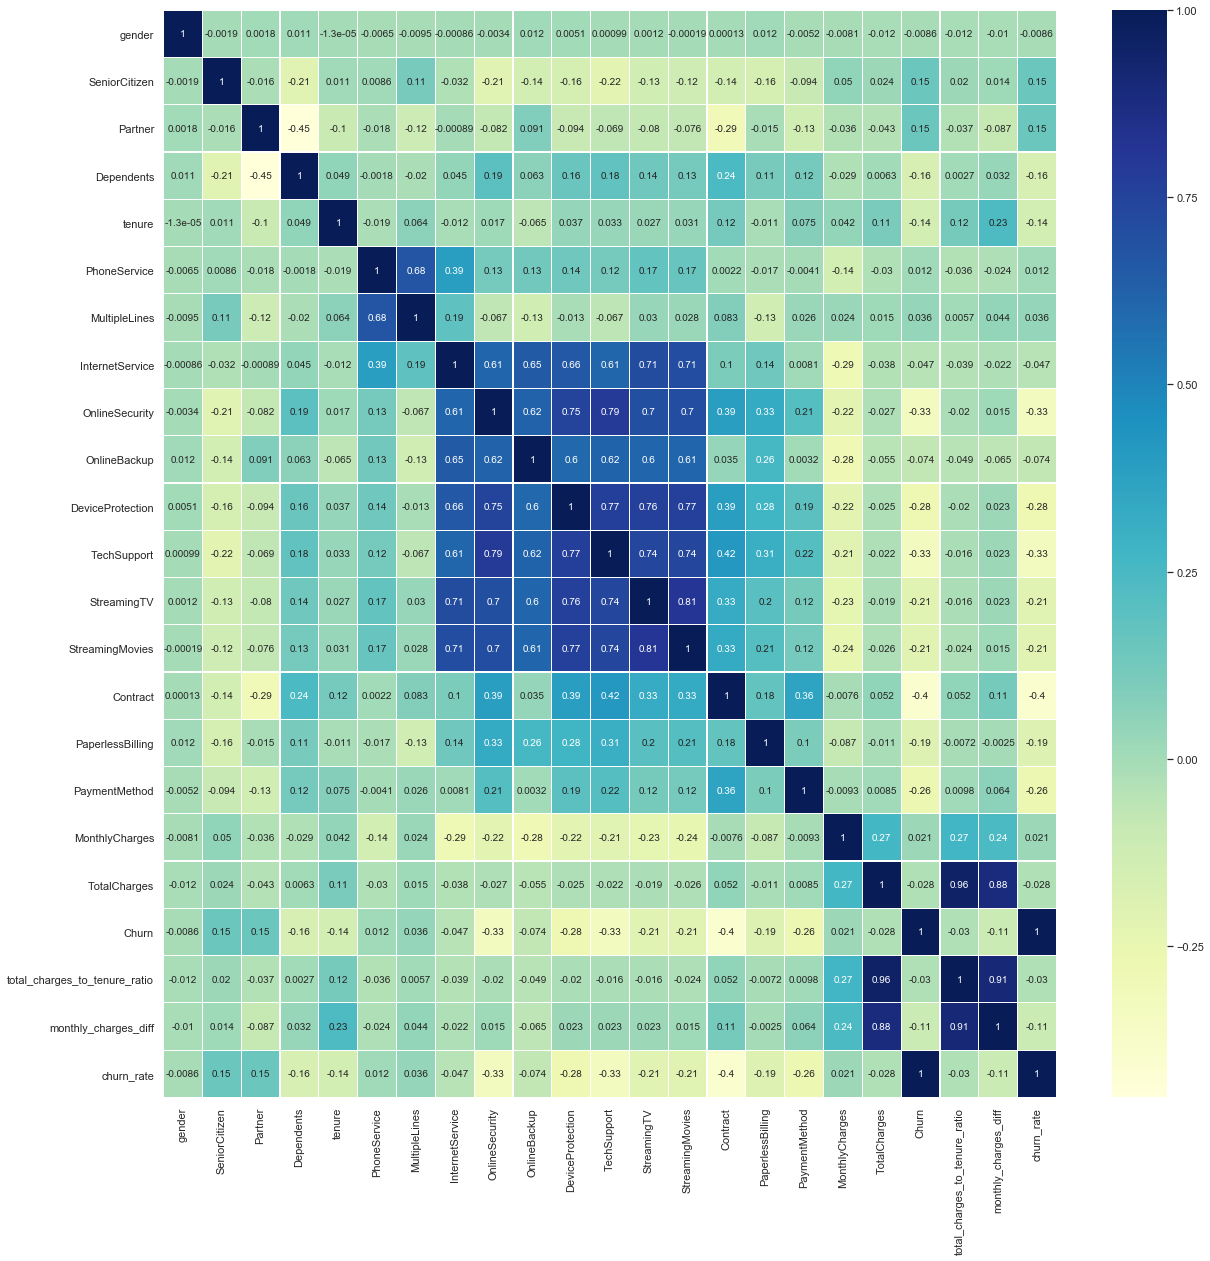

In [29]:
plt.figure(figsize=(20, 20))
df.drop(['churn_rate', 'total_charges_to_tenure_ratio', 'monthly_charges_diff'], axis=1, inplace=False)
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.2, cmap="YlGnBu", annot=True)

## Feature Importance

To get some preliminary feature importances we will use the Random Forest classifier, an well know decision-tree based model. I've used one-hot encode to encode the categorical features and dropped the 'No' columns for binary features. I've also manually tested a few hyperparameters to get a better model.

The importances are the mean decrease in impurity for each feature across all trees.


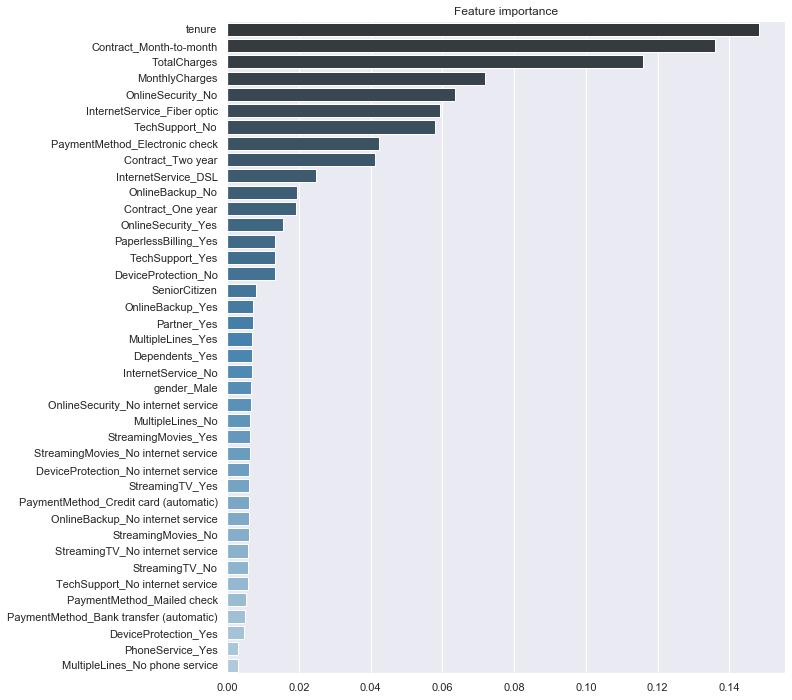

In [30]:
params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5000, 'max_depth': 8}
# One-hot encode
df = pd.get_dummies(df)

# Drop redundant columns (for features with two unique values)
drop = ['Churn_Yes', 'Churn_No', 'gender_Female', 'Partner_No',
        'Dependents_No', 'PhoneService_No', 'PaperlessBilling_No',
        'churn_rate', 'total_charges_to_tenure_ratio',
        'monthly_charges_diff']
x, y = df.drop(drop, axis=1), df['Churn_Yes']

# Fit RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)

# Plot features importances
imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

The importances are in line with our previous analysis. The three numerical features are good predictors for churn, specially `tenure`. 

As we've seen, **customers with Fiber optic are very likely to churn**, while **those with long term contracts are not**. On the other hand, `gender` and `streaming` are not important features.

It might be interesting to drop additional services with the label 'No internet service', since they are highly correlated.

---
After going through the above EDA we will develop some predictive models and compare them.

We will develop LogisticRegression, RandomForest, SVM, ADABoost and XGBoost


In [31]:
df2 = df_orig.copy(deep=True)

#Removing missing values 
df2.dropna(inplace = True)

#Remove customer IDs from the data set
df2 = df2.iloc[:,1:]

df2.replace(to_replace='Yes', value=1, inplace=True)
df2.replace(to_replace='No', value=0, inplace=True)
df2['gender'].replace(to_replace='Male', value=1, inplace=True)
df2['gender'].replace(to_replace='Female', value=0, inplace=True)

In [32]:
new_df = df2.iloc[:, :-3]
df_cat = pd.get_dummies(new_df)
df_cat.head(7).T

,0,1,2,3,4,5,6
gender,0,1,1,1,0,0,1
SeniorCitizen,0,0,0,0,0,0,0
Partner,1,0,0,0,0,0,0
Dependents,0,0,0,0,0,0,1
tenure,1,34,2,45,2,8,22
PhoneService,0,1,1,0,1,1,1
PaperlessBilling,1,0,1,0,1,1,1
MultipleLines_0,0,1,1,0,1,0,0
MultipleLines_1,0,0,0,0,0,1,1
MultipleLines_No phone service,1,0,0,1,0,0,0


Now let's build few predictive models and compare them to find the best one. The task here will be to classify whether or not the customer will churn, so we will have to scale our input values between **0** and **1**


In [33]:
X = df_cat
y = df2['Churn'].values

features = X.columns.values
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Logistic Regression

Accuracy: 0.7977288857345636 

gender                                    -0.07
SeniorCitizen                              0.24
Partner                                    0.03
Dependents                                -0.23
tenure                                    -2.49
PhoneService                              -0.20
PaperlessBilling                           0.36
MultipleLines_0                           -0.28
MultipleLines_1                            0.08
MultipleLines_No phone service            -0.03
InternetService_0                         -0.18
InternetService_DSL                       -0.45
InternetService_Fiber optic                0.40
OnlineSecurity_0                           0.15
OnlineSecurity_1                          -0.20
OnlineSecurity_No internet service        -0.18
OnlineBackup_0                             0.08
OnlineBackup_1                            -0.14
OnlineBackup_No internet service          -0.18
DeviceProtection_0                        -0.03
DevicePro

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


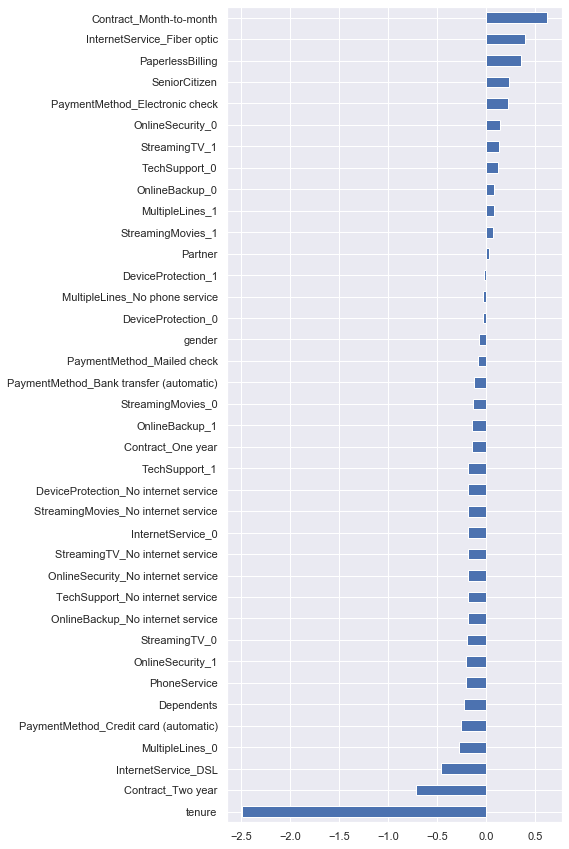

In [34]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

pred_log_reg = log_reg.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_test, pred_log_reg), '\n')

# To get the weights of all the variables
weights_LogReg = pd.Series(log_reg.coef_[0], index=X.columns.values)
print(weights_LogReg)
plt.figure(figsize=(6, 15))
weights_LogReg.sort_values().plot(kind='barh')

As we can see, some variables are negatively correlated with the predicted variable (Churn), while some have positively. Negative correlation means that likeliness of churn decreases with that variable. 

Let me interpret some findings from above plot,

1. As we have seen in our EDA, having a 2 month contract reduces chances of churn. 2 month contract along with tenure have the most negative relation with Churn as predicted by logistic regressions.


2. Total charges, monthly contracts, fibre optic internet services and seniority can lead to higher churn rates. This is interesting because although fibre optic services are faster, customers are likely to churn because of it. 

I don't understad why this is happening.

Till the time let's have a look at other algorithms.

### Random Forest

Accuracy: 0.7934705464868701 

gender                                     2.56e-03
SeniorCitizen                              5.48e-03
Partner                                    4.44e-03
Dependents                                 5.34e-03
tenure                                     1.90e-01
PhoneService                               2.05e-03
PaperlessBilling                           9.99e-03
MultipleLines_0                            4.29e-03
MultipleLines_1                            5.43e-03
MultipleLines_No phone service             2.11e-03
InternetService_0                          7.24e-03
InternetService_DSL                        2.79e-02
InternetService_Fiber optic                7.26e-02
OnlineSecurity_0                           7.84e-02
OnlineSecurity_1                           1.86e-02
OnlineSecurity_No internet service         8.61e-03
OnlineBackup_0                             3.57e-02
OnlineBackup_1                             1.05e-02
OnlineBackup_No internet service 

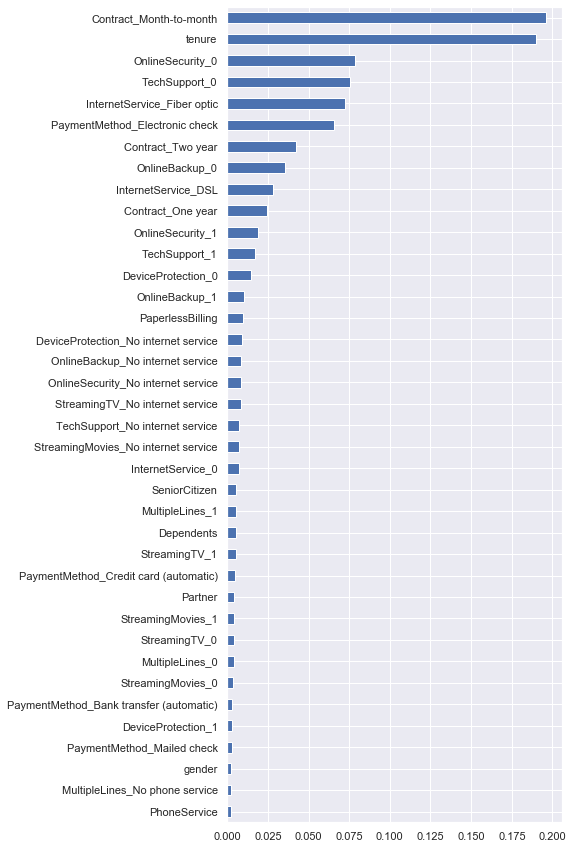

In [35]:
rf = RandomForestClassifier(n_estimators=1000,
                            oob_score = True,
                            n_jobs = -1,
                            random_state =50,
                            max_features = "auto",
                            max_leaf_nodes = 30)
rf.fit(X_train, y_train)

# Make predictions
pred_rf = rf.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_test, pred_rf), '\n')
importances = rf.feature_importances_
weights_RanFor = pd.Series(importances,
                 index=X.columns.values)
print(weights_RanFor)
plt.figure(figsize=(6, 15))
weights_RanFor.sort_values().plot(kind = 'barh')

1. From random forest algorithm, monthly contract, tenure and total charges are the most important predictor variables to predict churn.


2. The results from random forest are very similar to that of the logistic regression and in line to what we had expected from our EDA

### AdaBoost

Accuracy: 0.7906316536550745 

gender                                     0.02
SeniorCitizen                              0.02
Partner                                    0.02
Dependents                                 0.02
tenure                                     0.44
PhoneService                               0.00
PaperlessBilling                           0.04
MultipleLines_0                            0.04
MultipleLines_1                            0.00
MultipleLines_No phone service             0.00
InternetService_0                          0.00
InternetService_DSL                        0.02
InternetService_Fiber optic                0.02
OnlineSecurity_0                           0.04
OnlineSecurity_1                           0.02
OnlineSecurity_No internet service         0.00
OnlineBackup_0                             0.02
OnlineBackup_1                             0.00
OnlineBackup_No internet service           0.00
DeviceProtection_0                         0.02
DevicePro

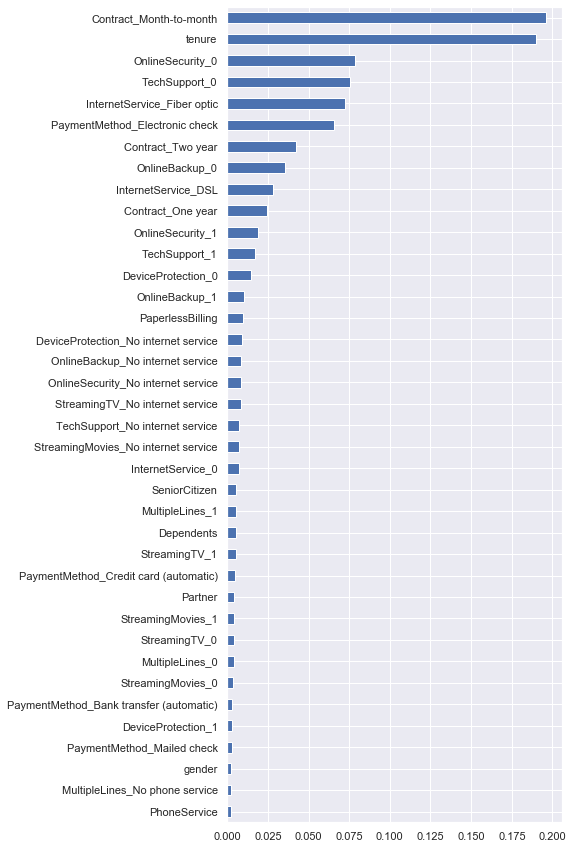

In [36]:
model_AdaB = AdaBoostClassifier()
model_AdaB.fit(X_train,y_train)
preds_adaB = model_AdaB.predict(X_test)
metrics.accuracy_score(y_test, preds_adaB)
print('Accuracy:', metrics.accuracy_score(y_test, preds_adaB), '\n')
importances = model_AdaB.feature_importances_
weights_AdaB = pd.Series(importances,
                 index=X.columns.values)
print(weights_AdaB)
plt.figure(figsize=(6, 15))
weights_RanFor.sort_values().plot(kind = 'barh')

### XGBoost

Accuracy: 0.7963094393186657 

gender                                     3.99e-03
SeniorCitizen                              7.58e-03
Partner                                    8.84e-04
Dependents                                 9.47e-03
tenure                                     2.44e-02
PhoneService                               8.63e-03
PaperlessBilling                           2.08e-02
MultipleLines_0                            1.60e-02
MultipleLines_1                            6.59e-03
MultipleLines_No phone service             0.00e+00
InternetService_0                          2.38e-02
InternetService_DSL                        8.12e-03
InternetService_Fiber optic                6.75e-02
OnlineSecurity_0                           6.02e-02
OnlineSecurity_1                           3.17e-03
OnlineSecurity_No internet service         0.00e+00
OnlineBackup_0                             1.66e-02
OnlineBackup_1                             2.77e-03
OnlineBackup_No internet service 

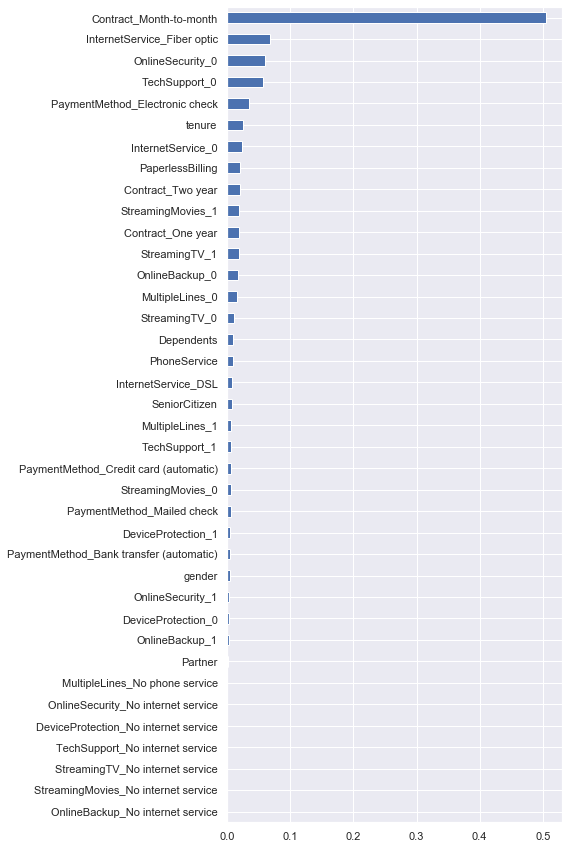

In [37]:
model_XGB = XGBClassifier()
model_XGB.fit(X_train, y_train)
preds_XGB = model_XGB.predict(X_test)
metrics.accuracy_score(y_test, preds_XGB)
print('Accuracy:', metrics.accuracy_score(y_test, preds_XGB), '\n')

importances = model_XGB.feature_importances_
weights_XGB = pd.Series(importances, index=X.columns.values)
print(weights_XGB)
plt.figure(figsize=(6, 15))
weights_XGB.sort_values().plot(kind = 'barh')

### SVM

In [38]:
model_svm = SVC(kernel='linear') 
model_svm.fit(X_train, y_train)
pred_svm = model_svm.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_test, pred_svm), '\n')

feature_importance = list(zip(model_svm.coef_[0], X.columns.values))
print(feature_importance)

Accuracy: 0.8019872249822569 

[(-0.06863855529502416, 'gender'), (0.1891323712694657, 'SeniorCitizen'), (0.038319716639989565, 'Partner'), (-0.13569238191669797, 'Dependents'), (-2.2588124642999787, 'tenure'), (-0.1590262914996856, 'PhoneService'), (0.2349092751758235, 'PaperlessBilling'), (-0.18117253153104684, 'MultipleLines_0'), (0.022146240031133857, 'MultipleLines_1'), (0.15902629149982772, 'MultipleLines_No phone service'), (-0.06517967332294461, 'InternetService_0'), (-0.5182351141092454, 'InternetService_DSL'), (0.5834147874321616, 'InternetService_Fiber optic'), (0.16030487699413243, 'OnlineSecurity_0'), (-0.09512520367121624, 'OnlineSecurity_1'), (-0.06517967332294461, 'OnlineSecurity_No internet service'), (0.13959613113797786, 'OnlineBackup_0'), (-0.07441645781489115, 'OnlineBackup_1'), (-0.06517967332294461, 'OnlineBackup_No internet service'), (0.042444842245572545, 'DeviceProtection_0'), (0.022734831077343642, 'DeviceProtection_1'), (-0.06517967332294461, 'DeviceProtect

With SVM-Linear Kernel, I am able to achieve the slightly higher than all accuracy on test data to almost **80.19%**.

But clearly there's alot to be explored from this dataset.